In [ ]:
# -*- coding: utf-8 -*-
"""WheatDisease - VGG19.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1CkzCFiGadzE3Otmsj_GHfZoKmGUd6po_
"""

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import VGG19
import numpy as np
import pickle

# Load data and labels from saved numpy files
data = np.load('/content/drive/MyDrive/preprocessed_data.npy')
labels = np.load('/content/drive/MyDrive/preprocessed_labels.npy')

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

# Initialize the training data augmentation object with GPU optimized settings
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Initialize the validation/testing data augmentation object (with mean subtraction)
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

# Load the VGG19 network, ensuring the head FC layer sets are left off
baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the layers in the base model
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model with GPU-optimized settings
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model using GPU-optimized batch size and steps
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=128),  # Increased batch size
    steps_per_epoch=len(trainX) // 128,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 128,
    epochs=30
)

# Continue with the remaining part of your existing code to evaluate and save the model

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/30
25/25 [==============================] - 65s 2s/step - loss: 2.7033 - accuracy: 0.5391 - val_loss: 1.4434 - val_accuracy: 0.7305
Epoch 2/30
25/25 [==============================] - 34s 1s/step - loss: 1.2560 - accuracy: 0.6762 - val_loss: 0.8426 - val_accuracy: 0.7344
Epoch 3/30
25/25 [==============================] - 34s 1s/step - loss: 0.9656 - accuracy: 0.6841 - val_loss: 0.8012 - val_accuracy: 0.7812
Epoch 4/30
25/25 [==============================] - 34s 1s/step - loss: 0.7574 - accuracy: 0.7309 - val_loss: 0.6882 - val_accuracy: 0.8047
Epoch 5/30
25/25 [==============================] - 34s 1s/step - loss: 0.6972 - accuracy: 0.7512 - val_loss: 0.5418 - val_accuracy: 0.8320
Epoch 6/30
25/25 [==============================] - 34s 1s/step - loss: 0.6396 - accuracy: 0.7651 - val_loss: 0.4723 - val_accuracy: 0.8242
Epoch 7/30
25/25 [==============================] - 34s 1s/step - loss: 0.5981 - accuracy: 0.77

In [ ]:
#Save the Model and label file to Disk
moodel.save("E:\Wheat Disease Detection\activity_model.h5")
f = open("label", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
import matplotlib.pyplot as plt

18/18 [==============================] - 4s 232ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       255
           1       0.85      0.90      0.88       287
           2       0.93      0.93      0.93       322
           3       0.89      0.87      0.88       232

    accuracy                           0.90      1096
   macro avg       0.90      0.89      0.90      1096
weighted avg       0.90      0.90      0.90      1096



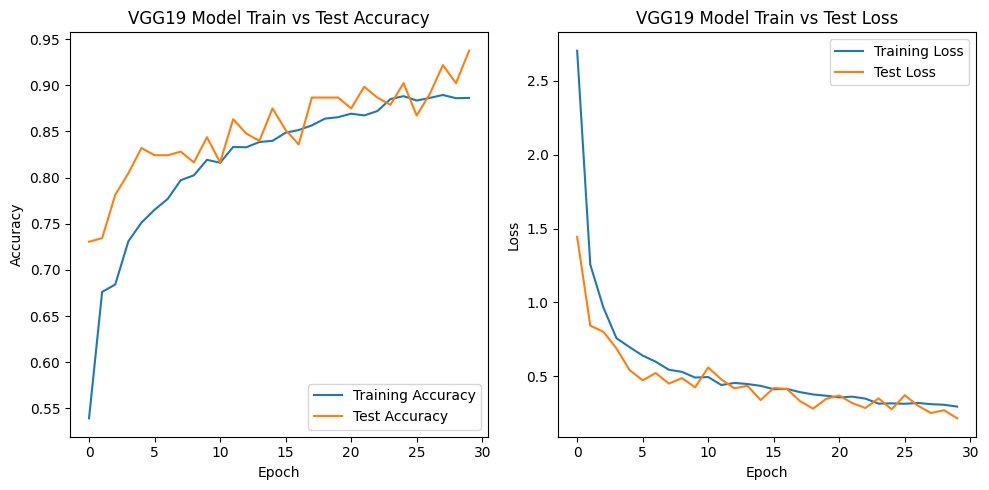

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# evaluate the network
predictions = model.predict(testX, batch_size=64)

# Convert class indices to class labels
class_labels = [str(cls) for cls in lb.classes_]

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=class_labels))

# Plot training loss and accuracy
N = 30
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('VGG19 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('VGG19 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Save the model and label file to disk
model.save("activity_model.h5")
f = open("label.bin", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import pickle
from collections import deque
from google.colab.patches import cv2_imshow

# Paths
model_path = '/content/E:/Wheat Disease Detection/activity_model.h5'
input_image_path = "/content/rust.jpg"
label_bin_path = "/content/E:/Wheat Disease Detection/label.bin"
output_image_path = '/content/crown_output'  # Path to save the output image

# Load the trained model and label binarizer from disk
model = load_model(model_path)
with open(label_bin_path, "rb") as f:
    lb = pickle.load(f)

# Initialize the image mean for mean subtraction along with the predictions queue
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
Q = deque(maxlen=128)

# Load image
image = cv2.imread(input_image_path)
if image is None:
    raise ValueError("Image not found")

# Preprocess image
output = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224)).astype("float32")
image -= mean

classes = ["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"]

# Make predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
Q.append(preds)
results = np.array(Q).mean(axis=0)
i = np.argmax(results)
label = lb.classes_[i]
label = classes[label]
print(label)
text = "PREDICTION: {}".format(label.upper())

# Put prediction text on image
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Show the output image
cv2_imshow(output)
cv2.waitKey(0)  # Wait indefinitely until a key is pressed
cv2.destroyAllWindows()



Output hidden; open in https://colab.research.google.com to view.